# 자연어처리 실습; 요약문 생성

### 결론
   - LSTM 에 어텐션 기법을 적용한 모델 완성.
   - 군데군데 드롭아웃 기법을 쓰면 성능이 조금 더 올라온다.
   - 아마 규제를 잘 덧대는 게 이번 모델 튜닝의 요점인 듯.
   - unrolling을 해서 속도를 살짝 끌어올릴 수 있다.
   - 이번 노크북은 조금 더 정리된 형태로 코딩 한 것 같다.
   - 하지만 여전히 실험, 디버깅, 회고 시간은 부족한.듯

In [1]:
import os

In [2]:
os.system("mkdir -p ~/aiffel/news_summarization/data")
os.system("ln -s ~/data/*.csv ~/aiffel/news_summarization/data")

ln: failed to create symbolic link '/aiffel/aiffel/news_summarization/data/Reviews.csv': File exists


256

In [ ]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

## 데이터 수집

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
# data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [10]:
import nltk
nltk.download('stopwords')
# 학습 노드와 같이 nltk 불용어 활용
nltk.download('stopwords')

from nltk.corpus import stopwords
print('불용어 개수 :', len(stopwords.words('english') ))
# print(stopwords.words('english'))

불용어 개수 : 179


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# 학습 노드와 같이 정규화 사전 활용
contractions = {
   "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
   "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
   "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
   "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
   "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
   "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
   "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
   "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
   "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
   "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
   "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
   "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
   "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
   "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
   "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
   "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
   "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
   "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
   "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
   "you're": "you are", "you've": "you have"
}

In [8]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/news_summary_more.csv", encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

data.head()

전체 샘플수 : 98401


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 추상적 요약 -- 데이터 전처리

In [13]:
data = data[["text", "headlines"]]
# Column 이름 변경
data = data.rename(columns={"text": "Text", "headlines": "Summary"})

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360
전체 샘플수 : 98360


In [76]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").get(" ") # <br />, <a href = ...> 등의 html 태그 제거; .get(" ")사용
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [16]:
clean_text = []

for txt in data["Text"]:
    clean_text.append(preprocess_sentence(txt))

print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [18]:
clean_summary = []

for smm in data["Summary"]:
    clean_summary.append(preprocess_sentence(smm, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [19]:
data['Text'] = clean_text
data['Summary'] = clean_summary

data.replace('', np.nan, inplace=True)

In [20]:
data.isnull().sum()

Text       0
Summary    0
dtype: int64

In [21]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


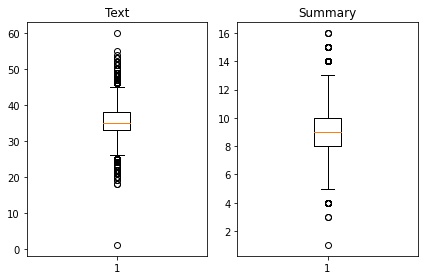

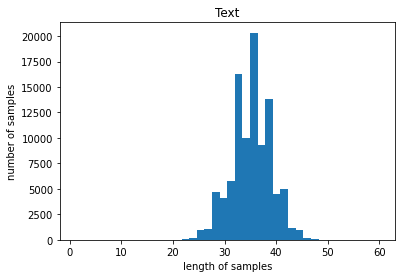

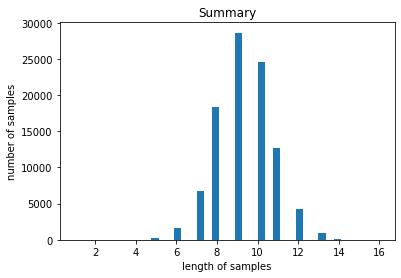

In [22]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
text_max_len = 38
summary_max_len = 11

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [29]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [30]:
data = data[data['Text'].apply(
                lambda i: not len(i.split())>text_max_len)]
data = data[data['Summary'].apply(
                lambda i: not len(i.split())>summary_max_len)]

In [31]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 75754


In [32]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,andhra pradesh cm chandrababu naidu said met u...,called pm modi sir times to satisfy his ego an...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


In [ ]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [34]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[30444 67274 21455 ... 22244 49912 14666]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [36]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15150


In [37]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 60604
훈련 레이블의 개수 : 60604
테스트 데이터의 개수 : 15150
테스트 레이블의 개수 : 15150


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [38]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [47]:
threshold = 5
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 60254
등장 빈도가 4번 이하인 희귀 단어의 수: 37451
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22803
단어 집합에서 희귀 단어의 비율: 62.15520961263983
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1007031187630094


In [48]:
# 포함되지 않은 희귀 단어 등장 비율이 3%대 정도로 유지
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [49]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[599, 58, 57, 15, 4220, 53, 3439, 80, 83, 47, 591, 6945, 5545, 85, 481, 3440, 4133, 6, 83, 1003, 234, 120, 178, 8, 85, 82, 3709, 481, 1744, 393, 81], [30, 816, 58, 16679, 8391, 13036, 6946, 365, 22, 426, 67, 706, 16, 1003, 2728, 3902, 848, 7, 1535, 11629, 232, 658, 695, 848, 740, 1437, 262, 1043, 1], [1558, 1093, 179, 1079, 355, 4650, 6523, 290, 6316, 563, 1047, 1187, 15, 1, 6947, 86, 289, 8392, 1, 2815, 779, 2905, 1047, 1093, 319, 6523, 1194, 85, 2065, 1886, 29, 12, 174]]


In [50]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [58]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27100
등장 빈도가 5번 이하인 희귀 단어의 수: 18033
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9067
단어 집합에서 희귀 단어의 비율: 66.54243542435424
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.609473821477473


In [59]:
# 포함되지 않은 희귀 단어 등장 비율이 5%대 정도; 단어 집합의 크기 9,000
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4003, 579, 1928, 551, 3, 69, 56, 59, 4354], [1, 19, 654, 46, 5, 5797, 4, 126, 63], [1, 973, 86, 385, 3, 4004, 608, 70, 204, 4526, 614, 280], [1, 472, 527, 3, 638, 44, 2409, 3286, 4, 2526], [1, 42, 1733, 1413, 156, 2351, 1437, 59, 639, 722]]
target
decoder  [[4003, 579, 1928, 551, 3, 69, 56, 59, 4354, 2], [19, 654, 46, 5, 5797, 4, 126, 63, 2], [973, 86, 385, 3, 4004, 608, 70, 204, 4526, 614, 280, 2], [472, 527, 3, 638, 44, 2409, 3286, 4, 2526, 2], [42, 1733, 1413, 156, 2351, 1437, 59, 639, 722, 2]]


In [60]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 60604
훈련 레이블의 개수 : 60604
테스트 데이터의 개수 : 15149
테스트 레이블의 개수 : 15149


In [61]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 추상적 요약 -- 어텐션 메커니즘

### 함수형 API를 이용해서 인코더를 설계

In [87]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True
                     ,dropout = 0.4, recurrent_dropout = 0.4, unroll=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True
                     ,dropout = 0.4, recurrent_dropout = 0.4, unroll=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True
                     ,dropout = 0.4, recurrent_dropout = 0.4, unroll=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


In [89]:
# 디코더 설계
# decoder_inputs = Input(shape=(None,))
decoder_inputs = Input(shape=(summary_max_len,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True
                     ,dropout = 0.4, recurrent_dropout = 0.2, unroll=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [90]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 38, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 38, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 11)]         0                                            
____________________________________________________________________________________________

In [91]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
mc = ModelCheckpoint(filepath = "/aiffel/aiffel/news_summarization/model_proj.h5",
                    monitor='val_loss', save_best_only=True)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=256, callbacks=[mc], epochs=50)

Epoch 1/50
237/237 [==============================] - 94s 191ms/step - loss: 5.9985 - val_loss: 5.5860
Epoch 2/50
237/237 [==============================] - 39s 163ms/step - loss: 5.4802 - val_loss: 5.2707
Epoch 3/50
237/237 [==============================] - 39s 163ms/step - loss: 5.1972 - val_loss: 5.0289
Epoch 4/50
237/237 [==============================] - 39s 163ms/step - loss: 4.9839 - val_loss: 4.8583
Epoch 5/50
237/237 [==============================] - 39s 163ms/step - loss: 4.7971 - val_loss: 4.7158
Epoch 6/50
237/237 [==============================] - 39s 163ms/step - loss: 4.6343 - val_loss: 4.5975
Epoch 7/50
237/237 [==============================] - 39s 164ms/step - loss: 4.4974 - val_loss: 4.5075
Epoch 8/50
237/237 [==============================] - 39s 163ms/step - loss: 4.3744 - val_loss: 4.4216
Epoch 9/50
237/237 [==============================] - 39s 163ms/step - loss: 4.2617 - val_loss: 4.3503
Epoch 10/50
237/237 [==============================] - 39s 163ms/step - l

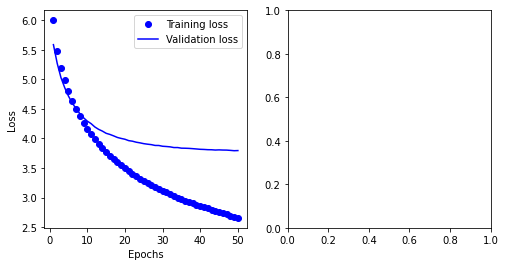

In [92]:
plot_training_history(history)

### 인퍼런스 모델

In [70]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

#### 아래 두 블럭을 실행해야 새로 학습된 모델의 인퍼런스를 실행할 수 있다.
   - 모델을 'build'하는 단계에 가중치 업데이트가 들어가는 듯.
   - 'input'부터 'output'까지 레이어를 타고 넘어가면서 구조와 가중치를 새로 참조하는 것으로 이해된다.
   - 애초에 새로 학습하는 단계에서 'compile'을 했기 때문일 수도 있겠다.
   - 'compile'없이 가중치만 새로 주고 추가학습은 가능할까?

In [109]:
# 인코더 설계; 이 줄에서 이전에 학습된 인코더 층들을 불러온다
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

# 이전에 학습된 디코더 임베딩 층을 불러온다
# decoder_inputs의 사이즈가 정해져 있어도 괜찮을까?
dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(
        dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [110]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [111]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 추상적 요약 -- 실제 결과와 요약문 비교

### 모델 테스트

In [112]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
    return temp

In [170]:
for i in range(k:=2345, k+100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former india captain sourav ganguly tweeted ex bcci president anurag thakur indian cricket needs back response thakur birthday wish thakur removed bcci president post supreme court january charges connection implementation lodha panel reforms cricket administration india 
실제 요약 : sostoken ganguly tells ex bcci prez indian cricket needs him back 
예측 요약 :  sehwag wishes bcci ganguly on birthday


원문 : researchers developed prototype smartphone case measure user blood pressure user put external pressure finger pressing sensor device let measure blood pressure meanwhile phone runs app ensure user maintains finger contact blood pressure 
실제 요약 : sostoken prototype phone case to check blood pressure developed 
예측 요약 :  device which can detect user with using developed


원문 : actor vidyut jammwal shared video twitter seen push ups using four glass bottles two hands two feet support vidyut training part ancient martial art form originated kerala trained since age three 
실제 요약 : sostoken v

예측 요약 :  aiims doctors to be alive in months


원문 : former facebook vp news feed adam appointed new head instagram following resignation instagram co founders kevin systrom mike krieger last week design graduate new york university adam joined facebook design team founded instagram bought facebook billion 
실제 요약 : sostoken facebook former news feed head named instagram head 
예측 요약 :  facebook shares his first ever cfo


원문 : delhi high court directed centre form three member committee probe alleged medical negligence safdarjung hospital hospital allegedly declared newborn dead baby still alive baby brought back hospital died later court said committee submit report within weeks 
실제 요약 : sostoken delhi hc orders probe into negligence at hospital 
예측 요약 :  hc allows abortion to death penalty for pregnant woman


원문 : giant infosys friday said newly appointed non executive chairman nandan nilekani receive remuneration current post last drawn remuneration fiscal ceased director lakh infosy

예측 요약 :  wife proposes to wife for not giving money to


원문 : actor shahid kapoor took instagram share picture daughter misha occasion st birthday saturday one wrote shahid alongside photo shahid currently vacation wife mira rajput daughter london celebrate birthday 
실제 요약 : sostoken shahid shares pic with daughter misha on her st birthday 
예측 요약 :  shahid shares pic with daughter in his th birthday


원문 : viral video suggested official trying fix railway track mumbai cloth railways clarified cloth mark replacement since paint stick rain however rti passenger rights activist samir demanded inquiry commissioner railway safety matter 
실제 요약 : sostoken railways denies fixing track with as video goes viral 
예측 요약 :  video shows mumbai local train during mumbai


원문 : woman named saba accused iifa plagiarism iifa awards used clips tribute video sridevi video saba made uploaded youtube march goes show sincere tribute saba wrote facebook account 
실제 요약 : sostoken iifa accused of plagiarism ov

예측 요약 :  pm modi inaugurates km in days


원문 : nasa astronauts whitson jack fischer successfully completed th spacewalk billion international space station spent hours minutes working outside station assembly maintenance earth orbiting laboratory iss first spacewalk conducted december nasa astronauts jerry ross jim newman 
실제 요약 : sostoken us astronauts complete th iss spacewalk 
예측 요약 :  nasa shares fall on mars days after days


원문 : tirumala tirupati devasthanams accused stealing ornaments lord venkateswara temple andhra decided exhibit jewellery end controversy jewellery put display media june theft allegations made former chief priest slapped crore defamation case 
실제 요약 : sostoken to exhibit tirumala temple jewellery amid theft allegations 
예측 요약 :  temple priest caught with fake notes in up


원문 : mumbai indians spinner harbhajan singh said pollution delhi made almost impossible breathe match delhi daredevils harbhajan revealed instagram post added players suffering bad throat g

예측 요약 :  govt proposes to reduce education of delhi


원문 : british built spacecraft taken first selfie space launched successfully weekend year journey mercury image snapped onboard camera shows spacecraft extended solar sun sensor bottom left place european japanese probes mercury orbit 
실제 요약 : sostoken spacecraft st selfie yr journey to 
예측 요약 :  first ever space station was born on this day


원문 : researchers university melbourne created world times thinner human hair seen without nano fabricated using direct laser writing system said scientists working create thin film could laid onto screen enable holographic display 
실제 요약 : sostoken world created in australia 
예측 요약 :  scientists claim of world most


원문 : former infosys cfo balakrishnan wednesday said board major infosys blaming co founder narayana murthy vishal sikka exit ceo hide failures murthy done great service stakeholders bringing corporate governance issues requesting accountability long term interest company said 
실제 

##  추출적 요약 -- Summa 이용

In [94]:
from summa.summarizer import summarize

In [119]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [120]:
print(summarize(text, ratio=0.005))

Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [126]:
len(text)

35932

#### 추출적 요약 라인의 출력이 안 나온다 무슨 일일까?

In [161]:
for i in range(50, 55):
    orig_txt = seq2text(encoder_input_test[i])
    smm_txt = summarize(orig_txt+".", words=summary_max_len)
    print("원문 :", orig_txt)
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
#     print("추출 요약 :", smm_txt*20)
    print("\n")

원문 : canada named destination year travel leisure magazine magazine said canada welcomed refugees immigrants hosting special events th anniversary celebrations travel leisure named city top city canada followed vancouver victoria montreal 
실제 요약 : sostoken canada named destination of the year by travel 
예측 요약 :  canada to host its first ever gay festival
추출 요약 : 


원문 : dollar slumped treasury bond dropped lowest level year us president donald trump said currency getting strong think dollar getting strong partially fault people confidence said trump also said brand china currency 
실제 요약 : sostoken after trump said dollar getting too strong currency plunges 
예측 요약 :  trump worst enemy of us economy in us
추출 요약 : 


원문 : video surfaced online showing patient dragged allegedly due lack stretchers government run hospital madhya pradesh jabalpur reportedly patient family said waited outside hospital stretcher minutes deciding drag inside 
실제 요약 : sostoken patient dragged to on at govt hospi

### 아래는 디버깅 코드
   - 시간 상 더 알아보기 힘들 듯.

In [145]:
from summa import summarizer

In [144]:
help(summarize)

Help on function summarize in module summa.summarizer:

summarize(text, ratio=0.2, words=None, language='english', split=False, scores=False, additional_stopwords=None)



In [146]:
help(summarizer)

Help on module summa.summarizer in summa:

NAME
    summa.summarizer

FUNCTIONS
    get_graph(text, language='english')
    
    log10(x, /)
        Return the base 10 logarithm of x.
    
    summarize(text, ratio=0.2, words=None, language='english', split=False, scores=False, additional_stopwords=None)

FILE
    /opt/conda/lib/python3.9/site-packages/summa/summarizer.py




In [157]:
a = os.system("cat /opt/conda/lib/python3.9/site-packages/summa/summarizer.py")

from math import log10

from .pagerank_weighted import pagerank_weighted_scipy as _pagerank
from .preprocessing.textcleaner import clean_text_by_sentences as _clean_text_by_sentences
from .commons import build_graph as _build_graph
from .commons import remove_unreachable_nodes as _remove_unreachable_nodes


def _set_graph_edge_weights(graph):
    for sentence_1 in graph.nodes():
        for sentence_2 in graph.nodes():

            edge = (sentence_1, sentence_2)
            if sentence_1 != sentence_2 and not graph.has_edge(edge):
                similarity = _get_similarity(sentence_1, sentence_2)
                if similarity != 0:
                    graph.add_edge(edge, similarity)

    # Handles the case in which all similarities are zero.
    # The resultant summary will consist of random sentences.
    if all(graph.edge_weight(edge) == 0 for edge in graph.edges()):
        _create_valid_graph(graph)


def _create_valid_graph(graph):
    nodes = graph.nodes()

    for i in range

In [162]:
from summa.preprocessing.textcleaner import clean_text_by_sentences

In [164]:
from summa.preprocessing import textcleaner

In [165]:
help(textcleaner)

Help on module summa.preprocessing.textcleaner in summa.preprocessing:

NAME
    summa.preprocessing.textcleaner

FUNCTIONS
    apply_filters(sentence, filters)
    
    clean_text_by_sentences(text, language='english', additional_stopwords=None)
        Tokenizes a given text into sentences, applying filters and lemmatizing them.
        Returns a SyntacticUnit list.
    
    clean_text_by_word(text, language='english', deacc=False, additional_stopwords=None)
        Tokenizes a given text into words, applying filters and lemmatizing them.
        Returns a dict of word -> syntacticUnit.
    
    deaccent(text)
        Remove accentuation from the given string.
    
    filter_words(sentences)
    
    get_sentences(text)
    
    init_textcleanner(language, additional_stopwords)
    
    merge_syntactic_units(original_units, filtered_units, tags=None)
    
    remove_stopwords(sentence)
    
    replace_abbreviations(text)
    
    replace_with_separator(text, separator, regexs)
    

In [166]:
b = os.system("cat /opt/conda/lib/python3.9/site-packages/summa/preprocessing/textcleaner.py")

import string
import unicodedata
import logging

logger = logging.getLogger('summa.preprocessing.cleaner')

try:
    from pattern.en import tag
    logger.info("'pattern' package found; tag filters are available for English")
    HAS_PATTERN = True
except ImportError:
    logger.info("'pattern' package not found; tag filters are not available for English")
    HAS_PATTERN = False

import re

from .snowball import SnowballStemmer
from .stopwords import get_stopwords_by_language
from summa.syntactic_unit import SyntacticUnit


# Utility functions adapted from Gensim v0.10.0:
# https://github.com/RaRe-Technologies/gensim/blob/0.10.0/gensim/utils.py
# https://github.com/RaRe-Technologies/gensim/blob/0.10.0/gensim/parsing/preprocessing.py


SEPARATOR = r"@"
RE_SENTENCE = re.compile('(\S.+?[.!?])(?=\s+|$)|(\S.+?)(?=[\n]|$)')
AB_SENIOR = re.compile("([A-Z][a-z]{1,2}\.)\s(\w)")
AB_ACRONYM = re.compile("(\.[a-zA-Z]\.)\s(\w)")
AB_ACRONYM_LETTERS = re.compile("([a-zA-Z])\.([a-zA-Z])\.")
UNDO_AB_S

In [163]:
help(clean_text_by_sentences)

Help on function clean_text_by_sentences in module summa.preprocessing.textcleaner:

clean_text_by_sentences(text, language='english', additional_stopwords=None)
    Tokenizes a given text into sentences, applying filters and lemmatizing them.
    Returns a SyntacticUnit list.



In [167]:
from summa import syntactic_unit

In [168]:
help(syntactic_unit)

Help on module summa.syntactic_unit in summa:

NAME
    summa.syntactic_unit

CLASSES
    builtins.object
        SyntacticUnit
    
    class SyntacticUnit(builtins.object)
     |  SyntacticUnit(text, token=None, tag=None)
     |  
     |  Methods defined here:
     |  
     |  __init__(self, text, token=None, tag=None)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  __repr__(self)
     |      Return repr(self).
     |  
     |  __str__(self)
     |      Return str(self).
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
     |  __weakref__
     |      list of weak references to the object (if defined)

FILE
    /opt/conda/lib/python3.9/site-packages/summa/syntactic_unit.py




In [169]:
c = os.system("cat /opt/conda/lib/python3.9/site-packages/summa/syntactic_unit.py")

class SyntacticUnit(object):

    def __init__(self, text, token=None, tag=None):
        self.text = text
        self.token = token
        self.tag = tag[:2] if tag else None  # just first two letters of tag
        self.index = -1
        self.score = -1

    def __str__(self):
        return "Original unit: '" + self.text + "' *-*-*-* " + "Processed unit: '" + self.token + "'"

    def __repr__(self):
        return str(self)
